<a href="https://colab.research.google.com/github/edwin-19/TransformersLatest/blob/main/Data2VecAction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data
- The following commands will download the standford data
- And extract it to a folder called data

In [1]:
!wget http://vision.stanford.edu/Datasets/Stanford40.zip
!unzip Stanford40.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/XMLAnnotations/phoning_128.xml  
  inflating: data/XMLAnnotations/phoning_129.xml  
  inflating: data/XMLAnnotations/phoning_130.xml  
  inflating: data/XMLAnnotations/phoning_131.xml  
  inflating: data/XMLAnnotations/phoning_132.xml  
  inflating: data/XMLAnnotations/phoning_133.xml  
  inflating: data/XMLAnnotations/phoning_134.xml  
  inflating: data/XMLAnnotations/phoning_135.xml  
  inflating: data/XMLAnnotations/phoning_136.xml  
  inflating: data/XMLAnnotations/phoning_137.xml  
  inflating: data/XMLAnnotations/phoning_138.xml  
  inflating: data/XMLAnnotations/phoning_139.xml  
  inflating: data/XMLAnnotations/phoning_140.xml  
  inflating: data/XMLAnnotations/phoning_141.xml  
  inflating: data/XMLAnnotations/phoning_142.xml  
  inflating: data/XMLAnnotations/phoning_143.xml  
  inflating: data/XMLAnnotations/phoning_144.xml  
  inflating: data/XMLAnnotations/phoning_145.xml  
  inflating: data/XMLAnnotation

# Display and show image
- Using the display function lets look at the iamge
- Please use all the data and build a classifier model
  - The data has been split inside the txt file for the folder ImageSplits

In [2]:
from IPython.display import Image

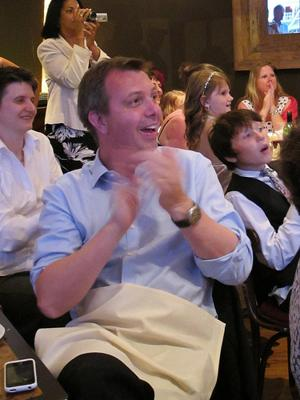

In [3]:
Image('data/JPEGImages/applauding_001.jpg')

# Build & Train model

In [4]:
!pip install -U albumentations
!pip install transformers
!pip install pytorch_lightning
!pip install torchmetrics
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 5.2 MB/s 
     |████████████████████████████████| 47.8 MB 1.9 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 62.9 MB/s 
     |████████████████████████████████| 86 kB 7.0 MB/s 
     |████████████████████████████████| 6.6 MB 43.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█████████████████

In [5]:
!pip install opencv-python==4.2.0.32

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.2 MB 1.5 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [6]:
from transformers import BeitFeatureExtractor, Data2VecVisionModel
from transformers import get_linear_schedule_with_warmup
import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import scikitplot as skplt
from sklearn.metrics import classification_report, matthews_corrcoef
from torchmetrics import Accuracy, MatthewsCorrCoef
import glob
import os
from PIL import Image
import numpy as np

# Download and load data


In [ ]:
pl.seed_everything(42)

In [7]:
with open('data/ImageSplits/train.txt', 'r') as txt_file:
  train_data = ['data/JPEGImages/' + item.replace('\n', '') for item in txt_file.readlines()]

with open('data/ImageSplits/test.txt', 'r') as txt_file:
  test_data = ['data/JPEGImages/' +  item.replace('\n', '') for item in txt_file.readlines()]

In [8]:
labels = np.unique(['_'.join(os.path.basename(item).split('_')[:-1]) for item in train_data])
label_map = dict([(label, index) for index, label in enumerate(labels)])
label_map

{'applauding': 0,
 'blowing_bubbles': 1,
 'brushing_teeth': 2,
 'cleaning_the_floor': 3,
 'climbing': 4,
 'cooking': 5,
 'cutting_trees': 6,
 'cutting_vegetables': 7,
 'drinking': 8,
 'feeding_a_horse': 9,
 'fishing': 10,
 'fixing_a_bike': 11,
 'fixing_a_car': 12,
 'gardening': 13,
 'holding_an_umbrella': 14,
 'jumping': 15,
 'looking_through_a_microscope': 16,
 'looking_through_a_telescope': 17,
 'phoning': 18,
 'playing_guitar': 19,
 'playing_violin': 20,
 'pouring_liquid': 21,
 'pushing_a_cart': 22,
 'reading': 23,
 'riding_a_bike': 24,
 'riding_a_horse': 25,
 'rowing_a_boat': 26,
 'running': 27,
 'shooting_an_arrow': 28,
 'smoking': 29,
 'taking_photos': 30,
 'texting_message': 31,
 'throwing_frisby': 32,
 'using_a_computer': 33,
 'walking_the_dog': 34,
 'washing_dishes': 35,
 'watching_TV': 36,
 'waving_hands': 37,
 'writing_on_a_board': 38,
 'writing_on_a_book': 39}

In [9]:
feature_extractor = BeitFeatureExtractor.from_pretrained("facebook/data2vec-vision-base-ft1k")
model = Data2VecVisionModel.from_pretrained("facebook/data2vec-vision-base-ft1k", add_pooling_layer=True)

Downloading:   0%|          | 0.00/302 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/68.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at facebook/data2vec-vision-base-ft1k were not used when initializing Data2VecVisionModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing Data2VecVisionModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Data2VecVisionModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Build dataset

In [10]:
class ActionDataset(Dataset):
  def __init__(self, images_path, label_map, feature_extractor, transforms=None):
    super(ActionDataset, self).__init__()
    self.images_path = images_path
    self.label_map = label_map
    self.feature_extractor = feature_extractor
    self.transforms = transforms

  def __len__(self):
    return len(self.images_path)

  def __getitem__(self, index):
    image_path = self.images_path[index]
    label = self.label_map['_'.join(os.path.basename(image_path).split('_')[:-1])]

    img = np.array(Image.open(image_path).convert('RGB'))

    if self.transforms:
      img = self.transforms(image=img)['image']

    feat = self.feature_extractor(img, return_tensors='pt')
    return {
        'image': feat['pixel_values'].squeeze(0),
        'label': label
    }

In [11]:
class ActionDataModule(pl.LightningDataModule):
  def __init__(self, train_images_path, test_images_path, label_map, feature_extractor, batch_size=64):
    super(ActionDataModule, self).__init__()

    self.transforms = A.Compose([
      A.HorizontalFlip(p=0.5),
      A.GaussNoise(p=0.2),
      A.Blur(blur_limit=3),
      A.OpticalDistortion(),
      A.GridDistortion(),
      A.HueSaturationValue(),
    ])

    self.label_map = label_map
    self.train_images_path = train_images_path
    self.test_images_path = test_images_path
    self.feature_extractor = feature_extractor
    self.batch_size = batch_size

  def setup(self, stage=None):
    self.train_dataset = ActionDataset(self.train_images_path, self.label_map, self.feature_extractor, transforms=self.transforms)
    self.test_dataset = ActionDataset(self.test_images_path, self.label_map, self.feature_extractor)

  def train_dataloader(self) -> DataLoader:
    return DataLoader(
        self.train_dataset, batch_size=self.batch_size, 
        num_workers=2, pin_memory=True,
        shuffle=True
    )

  def val_dataloader(self) -> DataLoader:
    return DataLoader(
        self.test_dataset, batch_size=self.batch_size, 
        num_workers=2, pin_memory=True,
        shuffle=False
    )

In [12]:
datamodule = ActionDataModule(train_data, test_data, label_map, feature_extractor, batch_size=64)

# Build Model

In [13]:
class ActionRecogModule(pl.LightningModule):
  def __init__(self, num_class, backbone, lr=5e-5):
    super(ActionRecogModule, self).__init__()
    self.backbone = backbone
    self.lr = lr

    self.criterion = nn.CrossEntropyLoss()
    self.train_acc = Accuracy()

    self.val_acc = Accuracy()
    self.val_mcc = MatthewsCorrCoef(num_class)

    self.classifier = nn.Sequential(
        nn.Linear(768, 768),
        nn.Dropout(0.2),
        nn.GELU(),
        nn.Linear(768, num_class)
    )

  def forward(self, image):
    pooled_output = self.backbone(image)[1]
    return self.classifier(pooled_output)

  def training_step(self, batch, batch_idx):
    img, label = batch['image'], batch['label']

    # Forward pass
    logits = self(img)

    loss = self.criterion(logits, label)
        
    self.train_acc(logits.argmax(dim=1), label)
    self.log('train_acc', self.train_acc, prog_bar=True)

    return loss

  def validation_step(self, batch, batch_idx):
    img, label = batch['image'], batch['label']

    # Forward pass
    logits = self(img)
    val_loss = self.criterion(logits, label)
        
    self.val_acc(logits.argmax(dim=1), label)
    self.val_mcc(logits.argmax(dim=1), label)

    self.log('val_acc', self.val_acc, prog_bar=True)
    self.log('val_mcc', self.val_mcc, prog_bar=True)

    return val_loss

  def predict_step(self, batch, batch_idx: int , dataloader_idx: int = None):
    return {
        'logits': self(batch['image']),
        'gt': batch['label']
    }

  def configure_optimizers(self):
    optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)

    return {
        'optimizer': optimizer,
    }

In [14]:
action_module = ActionRecogModule(len(label_map), model)

# Trainer

In [15]:
# Define callbacks
early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.02,
    patience=3,
    verbose=False,
    mode='max'
)

# Setup trainer call
trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu', devices=1,
    callbacks=[early_stopping]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(action_module, datamodule=datamodule)

Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                | Params
---------------------------------------------------
0 | backbone   | Data2VecVisionModel | 85.8 M
1 | criterion  | CrossEntropyLoss    | 0     
2 | train_acc  | Accuracy            | 0     
3 | val_acc    | Accuracy            | 0     
4 | val_mcc    | MatthewsCorrCoef    | 0     
5 | classifier | Sequential          | 621 K 
---------------------------------------------------
86.4 M    Trainable params
0         Non-trainable params
86.4 M    Total params
345.533   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [17]:
!nvidia-smi

Wed Jun  1 18:41:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    45W /  70W |   1448MiB / 15109MiB |     70%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Evaluate model

In [18]:
results = trainer.predict(action_module, datamodule.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 63it [00:00, ?it/s]

In [19]:
y_true = []
y_pred = []

for result in results:
  y_true.append(result['gt'].detach().cpu().numpy())
  y_pred.append(result['logits'].detach().cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [20]:
print(
    classification_report(y_true, y_pred.argmax(axis=1), target_names=list(label_map.keys()))
)

                              precision    recall  f1-score   support

                  applauding       0.71      0.52      0.60       184
             blowing_bubbles       0.95      0.71      0.81       159
              brushing_teeth       0.64      0.58      0.61       100
          cleaning_the_floor       0.91      0.87      0.89       112
                    climbing       0.94      0.94      0.94       195
                     cooking       0.84      0.60      0.70       188
               cutting_trees       0.92      0.79      0.85       103
          cutting_vegetables       0.63      0.72      0.67        89
                    drinking       0.70      0.69      0.69       156
             feeding_a_horse       0.99      0.92      0.95       187
                     fishing       0.95      0.91      0.93       173
               fixing_a_bike       0.96      0.85      0.90       128
                fixing_a_car       0.85      0.92      0.88       151
                   

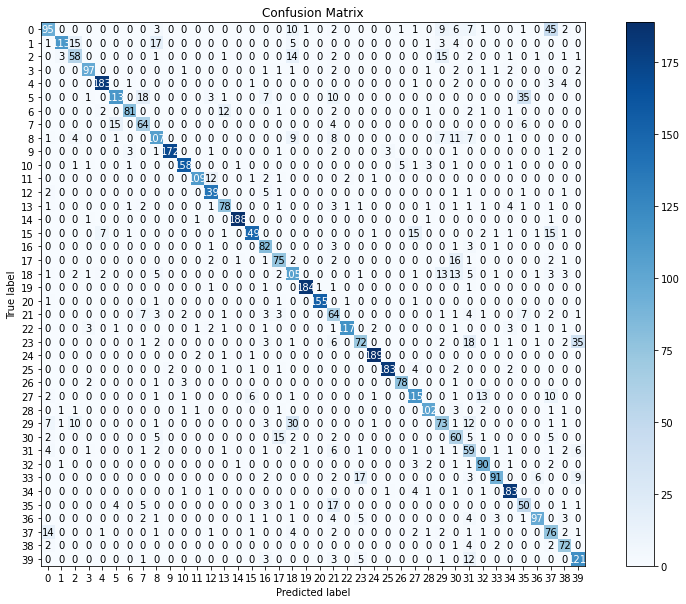

In [21]:
skplt.metrics.plot_confusion_matrix(y_true, y_pred.argmax(axis=1), figsize=(15, 10))

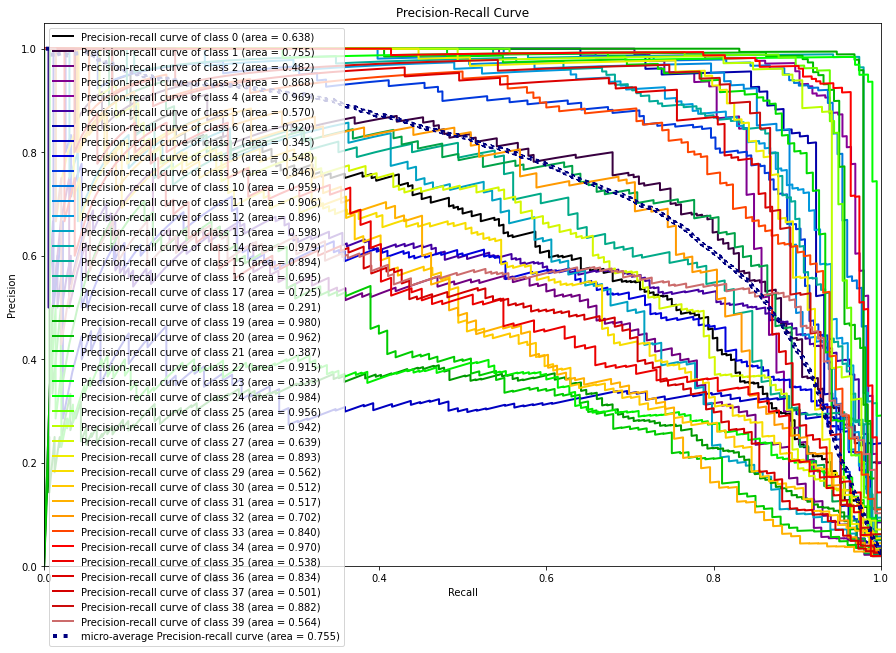

In [22]:
skplt.metrics.plot_precision_recall(y_true, y_pred, figsize=[15, 10])

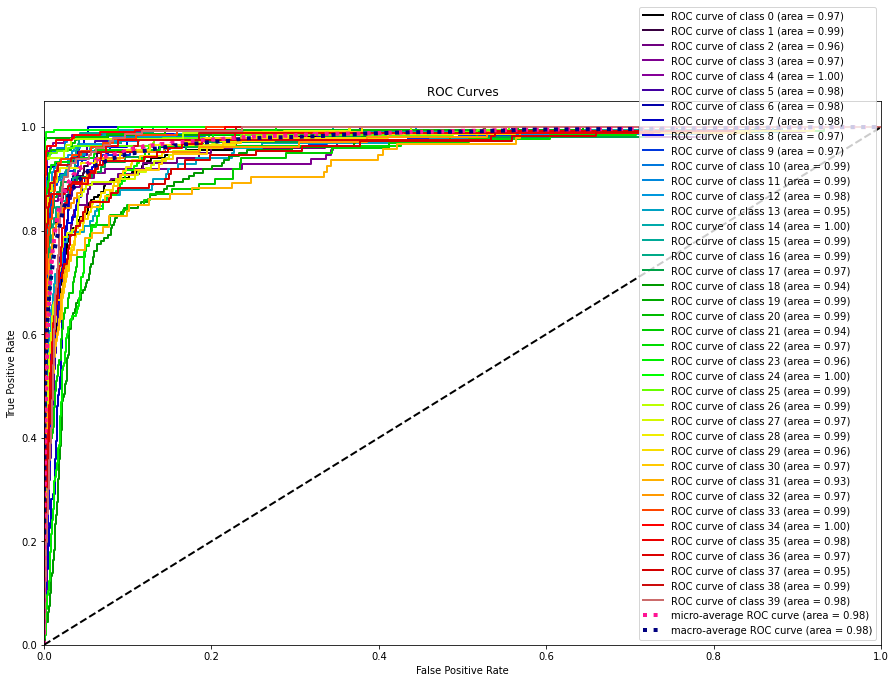

In [23]:
skplt.metrics.plot_roc(y_true, y_pred, figsize=[15, 10])